In [1]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
import transformers #huggingface transformers library
from transformers import pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (ElectraForSequenceClassification,TFElectraModel,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics)
from typing import List

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
df = pd.read_csv("data_transformer.csv")

In [5]:
df.head()

,text_clean,target
0,from a gender perspective paulgaard points out...,5
1,the average figure also masks large difference...,3
2,the israel oceanographic and limnological rese...,6
3,previous chapters have discussed ways to make ...,2
4,prescription rates appear to be higher where l...,8


<Axes: xlabel='target', ylabel='count'>

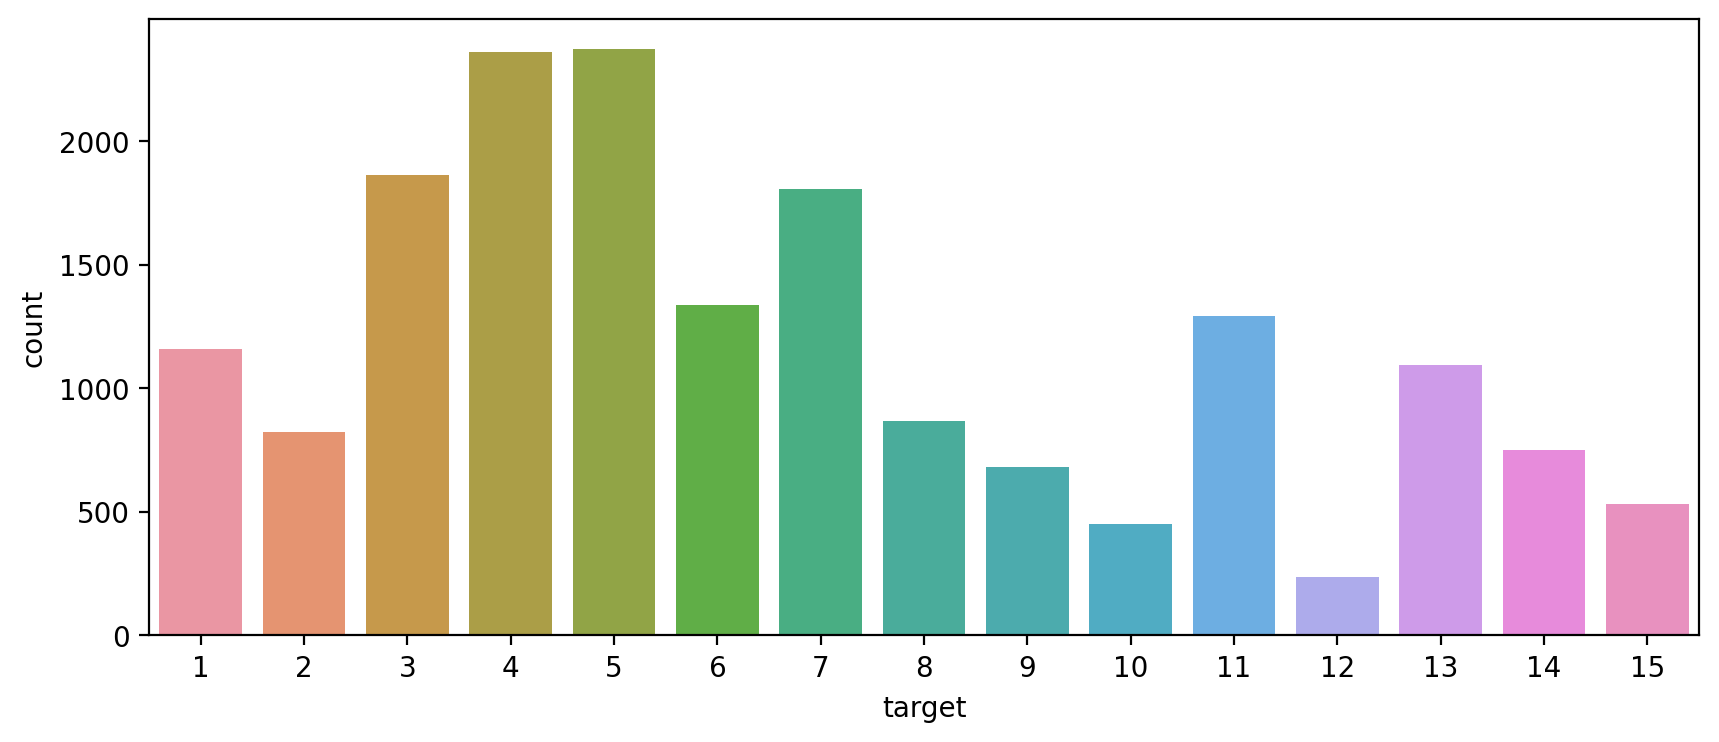

In [6]:
plt.figure(figsize=(10,4),dpi=200)
sns.countplot(x='target',data=df)

In [7]:
#since I am using bert-large-uncased as the model, I am converting each of the news headlines and descriptions into lower case.
df['text_clean'] = df['text_clean'].apply(lambda news: str(news).lower())

In [8]:
#calculating the length of headlines and descriptions
df['text_clean_len'] = df['text_clean'].apply(lambda x: len(str(x).split()))

In [9]:
df.describe()

,target,text_clean_len
count,17631.000000,17631.000000
mean,6.677103,89.446827
std,3.890232,28.881372
min,1.000000,23.000000
25%,4.000000,68.000000
50%,6.000000,84.000000
75%,9.000000,106.000000
max,15.000000,226.000000


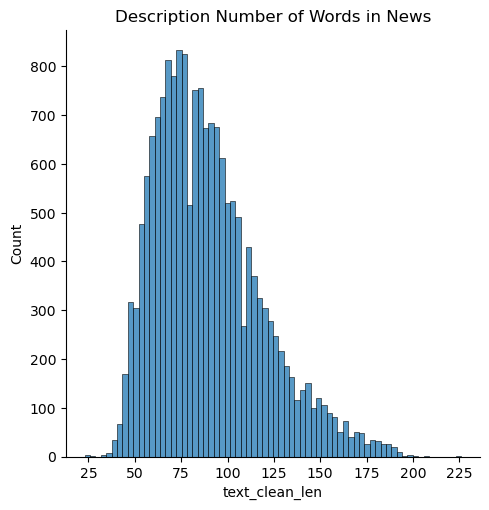

In [10]:
sns.displot(df['text_clean_len'])
plt.title('Description Number of Words in News')
plt.show()

In [11]:
from __future__ import print_function
import ipywidgets as widgets
import re


In [12]:

def clean_text(text):
    text = text.encode("ascii", errors="ignore").decode("ascii") #remove non-ascii, Chinese characters
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\n\n", " ", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(' +',' ', text).strip() # get rid of multiple spaces and replace with a single
    return text


In [13]:
df["text_clean"] = df["text_clean"].apply(clean_text)

In [14]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,         
        return_token_type_ids=False,
        padding='max_length',
        max_length=maxlen, 
        truncation=True
    )
    
    return np.array(enc_di['input_ids'])


In [15]:
model = ElectraForSequenceClassification.from_pretrained(
    "google/electra-small-discriminator", num_labels = 15)

tokenizer = ElectraTokenizerFast.from_pretrained(
    "google/electra-small-discriminator", do_lower_case=True) 

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [16]:
X_train,X_test ,y_train,y_test = train_test_split(df['text_clean'], 
                                                  df['target'], random_state = 42, test_size = 0.2)

In [17]:
Xtrain_encoded = regular_encode(X_train.to_list(), tokenizer, maxlen=300)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=16,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.to_list(), tokenizer, maxlen=300)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=16,dtype = 'int32')

In [18]:
from imblearn.over_sampling import RandomOverSampler

In [19]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [20]:
Xtrain_encoded,ytrain_encoded = oversample.fit_resample(Xtrain_encoded,ytrain_encoded)

In [21]:
Xtest_encoded,ytest_encoded = oversample.fit_resample(Xtest_encoded,ytest_encoded)

In [32]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 16 neurons as the number of unique categories is 16. 
    out = tf.keras.layers.Dense(15, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-04,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08), loss=loss, metrics=['accuracy'])
    return model

In [33]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('google/electra-small-discriminator')
    model = build_model(transformer_layer, max_len=300)
model.summary()

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 300)]            0         
                                                                 
 tf_electra_model_1 (TFElect  TFBaseModelOutputWithPas  13483008 
 raModel)                    tAndCrossAttentions(last            
                             _hidden_state=(None, 300            
                             , 256),                             
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                                 
 tf.__operators__.getitem_1   (None, 256)              0         
 (SlicingOpLambda)                                         

In [34]:
#creating the training and testing dataset.
BATCH_SIZE = 16*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [35]:
import os

In [36]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [37]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

In [38]:
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))


In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1)

In [41]:
#training for 2 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=2,callbacks=[[cp_callback,early_stop]]
)


Epoch 1/2
 79/987 [=>............................] - ETA: 1:17:04 - loss: 2.8864 - accuracy: 0.1052
Epoch 1: saving model to training_1\cp-0001.ckpt
159/987 [===>..........................] - ETA: 1:08:00 - loss: 2.7865 - accuracy: 0.1246
Epoch 1: saving model to training_1\cp-0001.ckpt
239/987 [======>.......................] - ETA: 1:00:38 - loss: 2.6795 - accuracy: 0.1553
Epoch 1: saving model to training_1\cp-0001.ckpt
319/987 [========>.....................] - ETA: 53:40 - loss: 2.5335 - accuracy: 0.2053
Epoch 1: saving model to training_1\cp-0001.ckpt
399/987 [===========>..................] - ETA: 47:41 - loss: 2.3725 - accuracy: 0.2608
Epoch 1: saving model to training_1\cp-0001.ckpt
479/987 [=============>................] - ETA: 41:36 - loss: 2.2349 - accuracy: 0.3058
Epoch 1: saving model to training_1\cp-0001.ckpt
559/987 [===============>..............] - ETA: 35:19 - loss: 2.0957 - accuracy: 0.3542
Epoch 1: saving model to training_1\cp-0001.ckpt
639/987 [================

In [42]:
from tensorflow import keras
path = './electra_model.h5'

In [43]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save(path)

In [44]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model(path,  custom_objects={"TFElectraModel":  TFElectraModel})

In [45]:
preds = reconstructed_model.predict(test_dataset)

249/249 [==============================] - 390s 2s/step


In [46]:
pred_classes = np.argmax(preds, axis = 1)
pred_classes

array([ 2,  6, 10, ..., 11,  6, 11], dtype=int64)

In [47]:
test_classes = np.argmax(ytest_encoded, axis = 1)

In [48]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(test_classes, pred_classes)}")

Accuracy is 0.8367654445002511


In [49]:
print(f"Precision is {sklearn.metrics.precision_score(test_classes, pred_classes,average= 'weighted')}")

Precision is 0.8375063463107405


In [50]:
print(f"Recall is {sklearn.metrics.recall_score(test_classes, pred_classes,average= 'weighted')}")

Recall is 0.8367654445002511


In [51]:
print(f"F1 Score is {sklearn.metrics.f1_score(test_classes, pred_classes,average= 'weighted')}")

F1 Score is 0.8331982919803546


In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

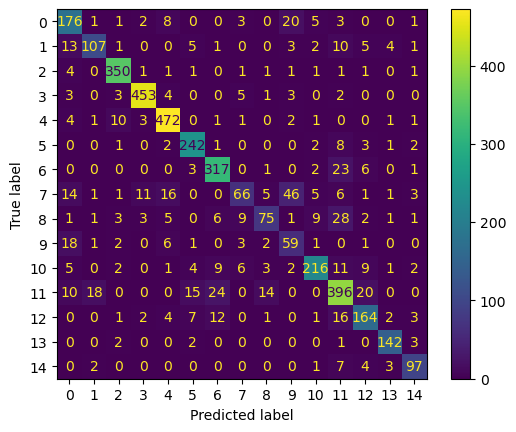

In [54]:
cm = confusion_matrix(test_classes, pred_classes)
ConfusionMatrixDisplay(cm).plot()

In [55]:
from sklearn.preprocessing import label_binarize

In [56]:
y_test = label_binarize(test_classes,classes=np.unique(test_classes))
y_pred = preds

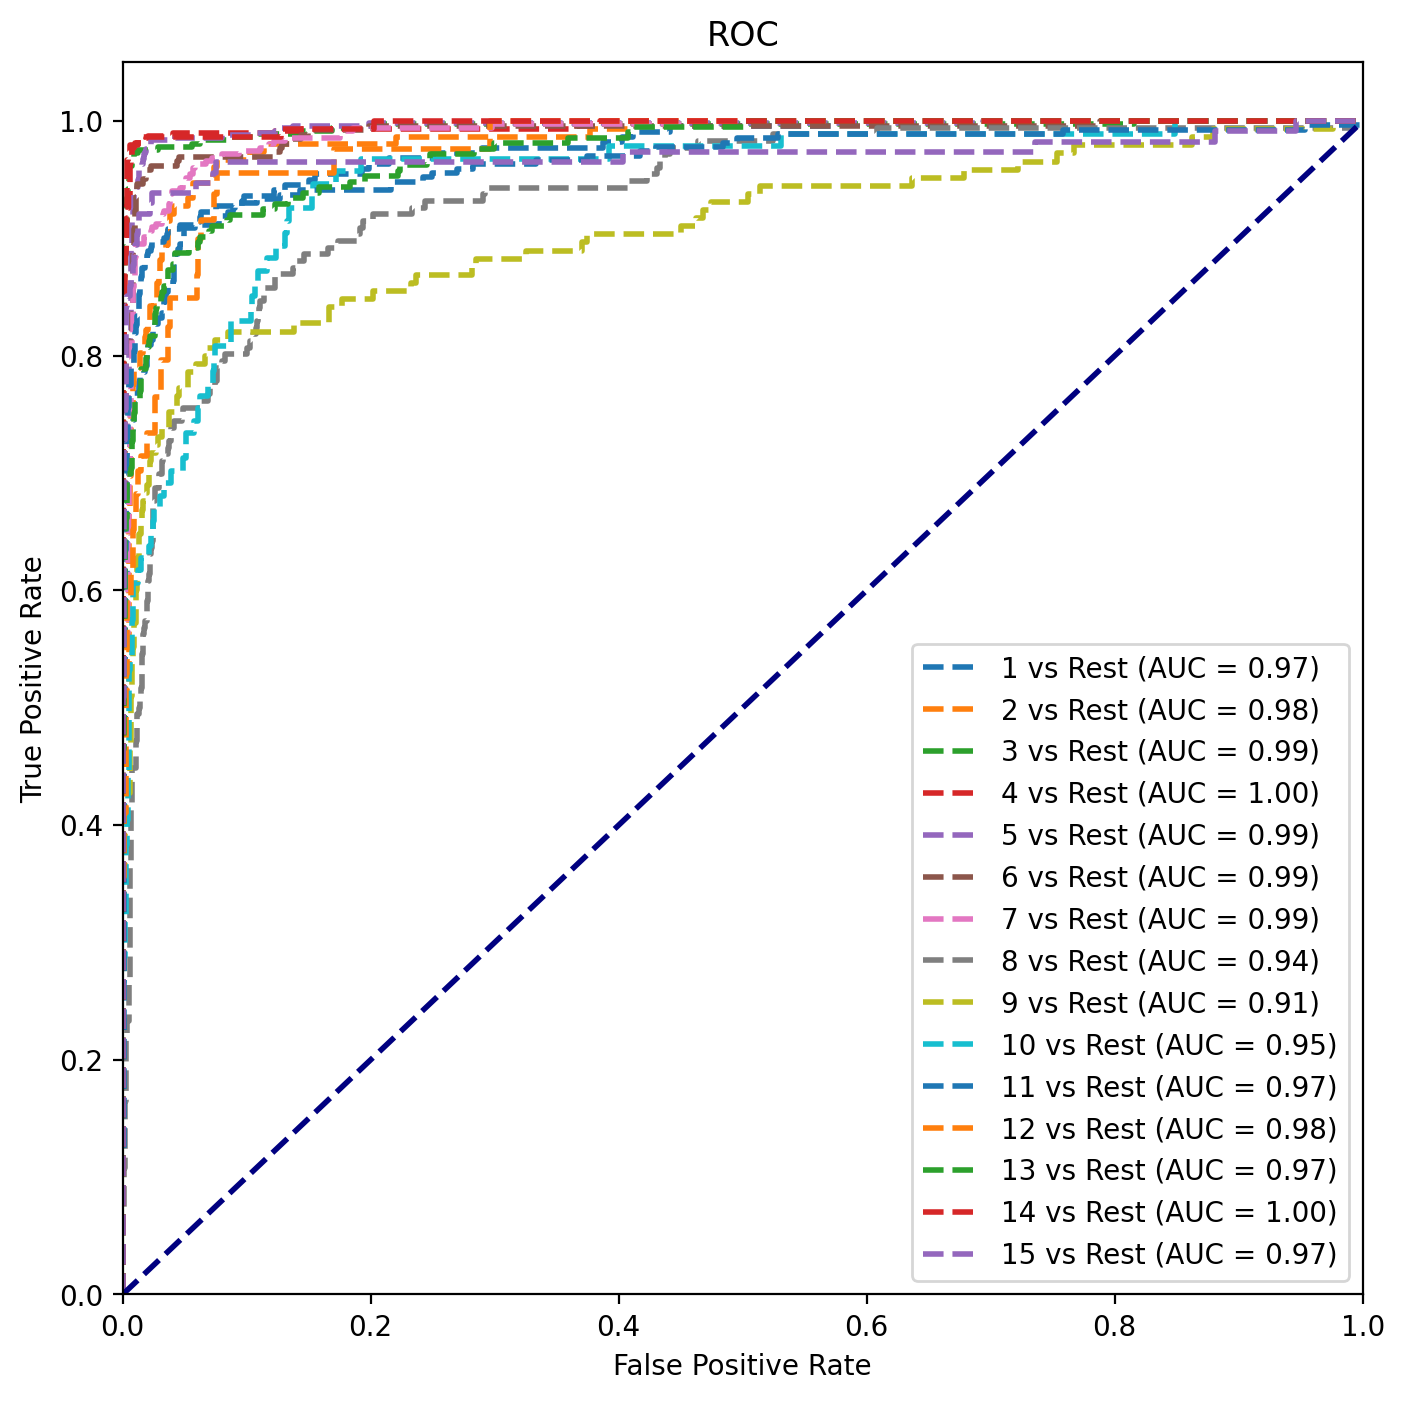

In [57]:
from sklearn.metrics import roc_curve, auc

# Learn to predict each class against the other


n_classes = 15 # number of class
plt.figure(figsize=(8,8),dpi=200)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i], )
    roc_auc[i] = auc(fpr[i], tpr[i])    
    
    lw = 2 # line_width
    plt.plot(fpr[i], tpr[i], linestyle='--',
    lw=lw, label='%s vs Rest (AUC = %0.2f)' % (i+1,roc_auc[i])) # Drawing Curve according to 15. class 
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [58]:
test_df = pd.read_excel("test_dataset_updated.xlsx")

In [59]:
test_df.head()

,News Summary,OSDG,OSDG Label
0,agricultural engineer eduardo assad has devot...,Climate Action,13
1,agricultural organizations are joining forces...,Zero Hunger,2
2,aim4c coalition pledged to accelerate innovat...,Climate Action,13
3,alaa abd el fattah one of egypts most high pr...,Climate Action,13
4,alcazar energy partners ii slp scsp aep ii br...,Affordable and Clean Energy,7


In [60]:
news = test_df['News Summary']

In [61]:
labels = test_df['OSDG Label']

In [62]:
def encode_news(new, tokenizer):
    news_encoded = regular_encode(new.tolist(), tokenizer, maxlen=300)
    news_dataset = (tf.data.Dataset.from_tensor_slices(news_encoded).batch(BATCH_SIZE))
    return news_dataset    

In [63]:
news_prepared = encode_news(news,tokenizer)

In [64]:
pred_class = reconstructed_model.predict(news_prepared)

111/111 [==============================] - 172s 2s/step


In [65]:
pred_classes = np.argmax(pred_class, axis = 1) + 1
pred_classes

array([13,  2,  2, ..., 13, 13,  1], dtype=int64)

In [66]:
result_df = pd.DataFrame({'news':test_df['News Summary'],'true_category':test_df['OSDG Label'], 'predicted_category':pred_classes})
result_df

,news,true_category,predicted_category
0,agricultural engineer eduardo assad has devot...,13,13
1,agricultural organizations are joining forces...,2,2
2,aim4c coalition pledged to accelerate innovat...,13,2
3,alaa abd el fattah one of egypts most high pr...,13,13
4,alcazar energy partners ii slp scsp aep ii br...,7,7
...,...,...,...
1770,Young activists from outside the country espec...,13,14
1771,Youth climate activism is bearing fruit our an...,13,5
1772,Youth climate activist greta thunberg has a bo...,13,13
1773,Zambia's environment minister collins nzovu de...,13,13


In [67]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.7966197183098591


In [68]:
print(f"Precision is {sklearn.metrics.precision_score(result_df['true_category'], result_df['predicted_category'],average= 'weighted')}")

Precision is 0.8449122980674129


In [69]:
print(f"Recall is {sklearn.metrics.recall_score(result_df['true_category'], result_df['predicted_category'],average= 'weighted')}")

Recall is 0.7966197183098591


In [70]:
print(f"F1 Score is {sklearn.metrics.f1_score(result_df['true_category'], result_df['predicted_category'],average= 'weighted')}")

F1 Score is 0.804020331869116


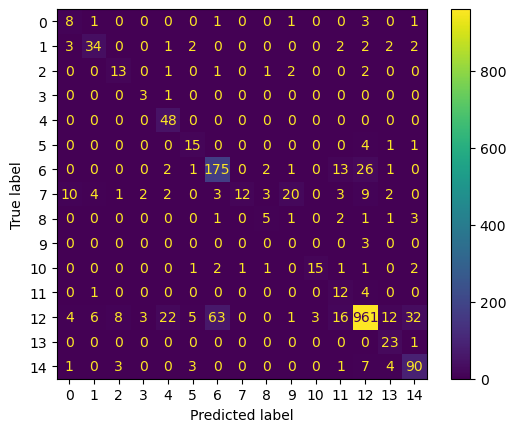

In [71]:
cm = confusion_matrix(result_df['true_category'], result_df['predicted_category'])
ConfusionMatrixDisplay(cm).plot()

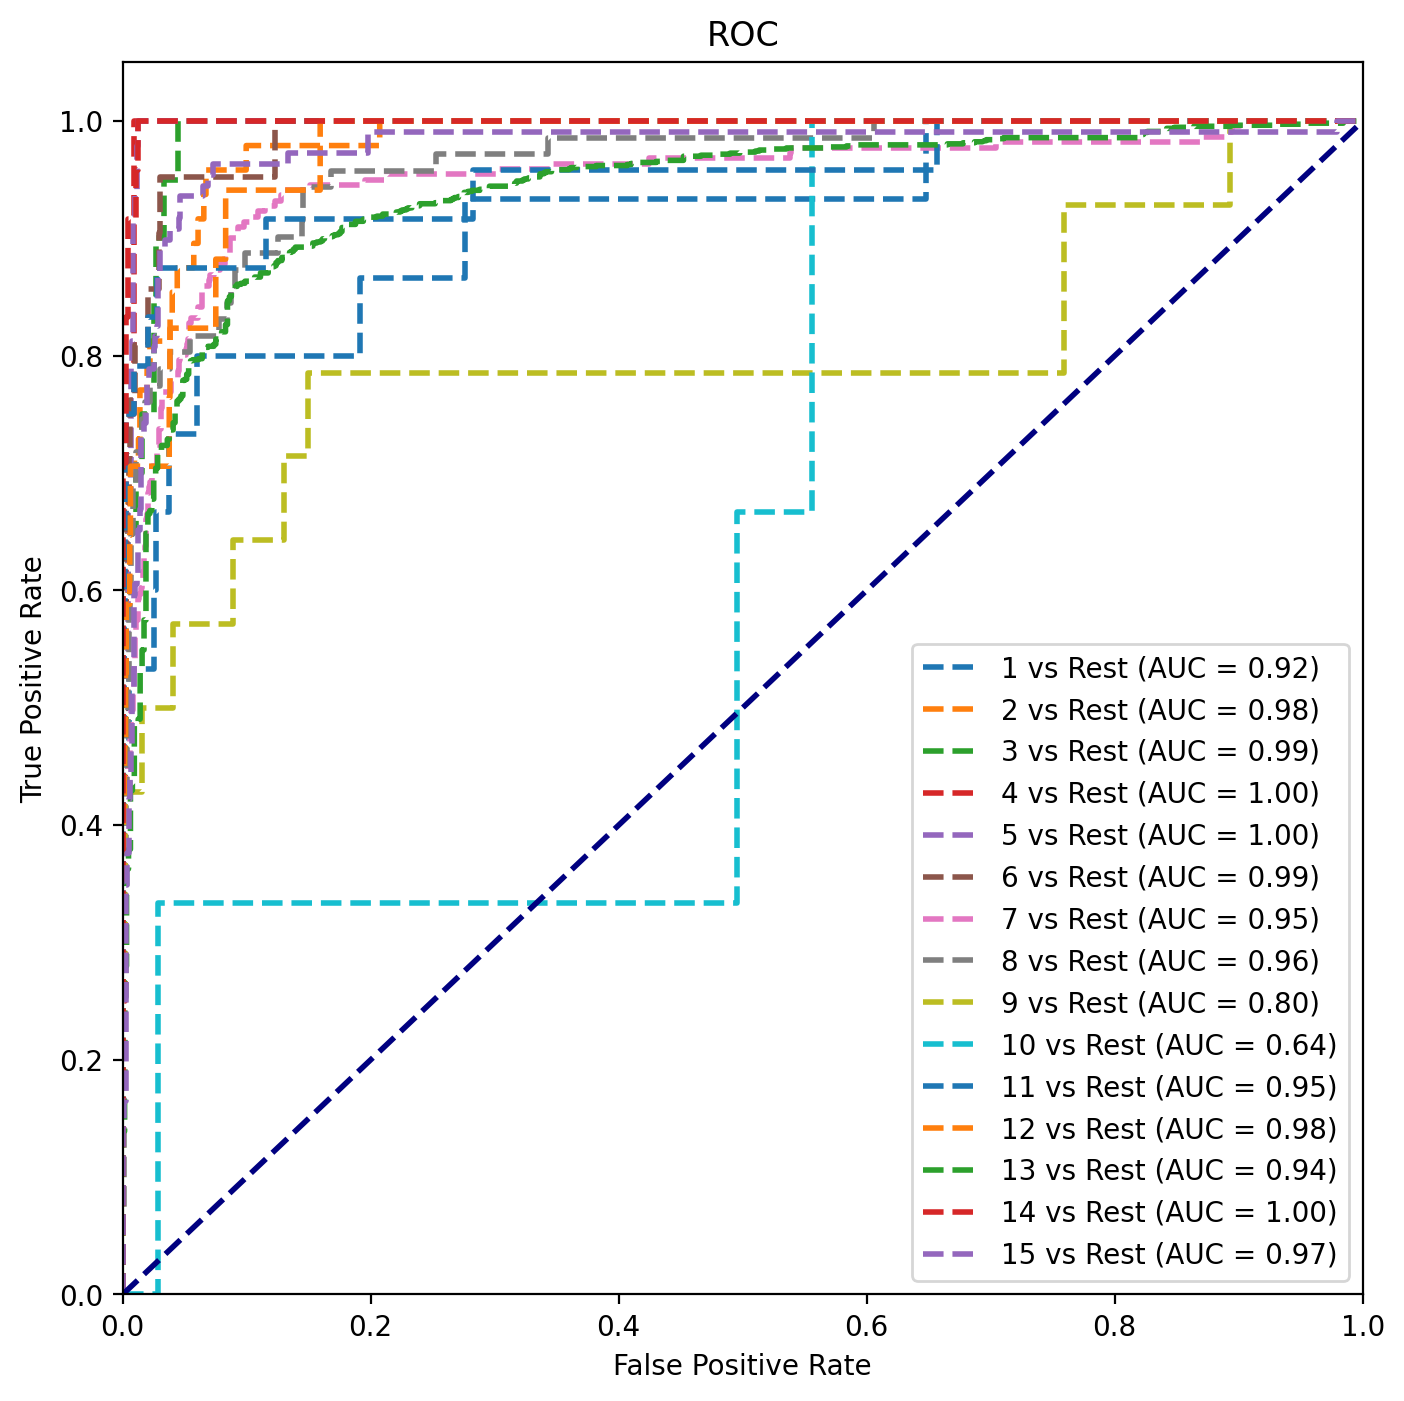

In [72]:
# Learn to predict each class against the other
y_test = label_binarize(result_df['true_category'],classes=np.unique(result_df['true_category']))
y_pred = pred_class

n_classes = 15 # number of class
plt.figure(figsize=(8,8),dpi=200)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i], )
    roc_auc[i] = auc(fpr[i], tpr[i])    
    
    lw = 2 # line_width
    plt.plot(fpr[i], tpr[i], linestyle='--',
    lw=lw, label='%s vs Rest (AUC = %0.2f)' % (i+1,roc_auc[i])) # Drawing Curve according to 15. class 
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [71]:
 # saving the excel
file_name = 'electra_results.xlsx'
result_df.to_excel(file_name)